<a href="https://colab.research.google.com/github/JohanFendi/Titanic/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt


url = "https://homl.info/titanic.tgz"
path = "datasets/titanic.tgz"

def load_data(url, path, dir_name):
  file_path = Path(path)
  if not file_path.is_file():
    Path(dir_name).mkdir(exist_ok=True,parents=True)
    respons = urllib.request.urlretrieve(url, file_path)
    with tarfile.open(file_path) as data_tarball:
      data_tarball.extractall(path=dir)


def get_titanic_data():
  return pd.read_csv(Path("datasets/titanic/test.csv")), pd.read_csv(Path("datasets/titanic/train.csv"))

test, train = get_titanic_data()



In [48]:
print(train.info())
print(train.head())
print(train["Embarked"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                      

(array([  2.,   5., 267.,  75.,  65.,  67.,  39., 104.,  58.,  23.,  46.,
         28.,  44.,  11.,  17.,   5.,  11.,   6.,   0.,   3.]),
 array([1.38941449, 1.63189213, 1.87436978, 2.11684742, 2.35932507,
        2.60180271, 2.84428036, 3.086758  , 3.32923565, 3.57171329,
        3.81419094, 4.05666858, 4.29914623, 4.54162387, 4.78410152,
        5.02657916, 5.26905681, 5.51153445, 5.7540121 , 5.99648974,
        6.23896739]),
 <BarContainer object of 20 artists>)

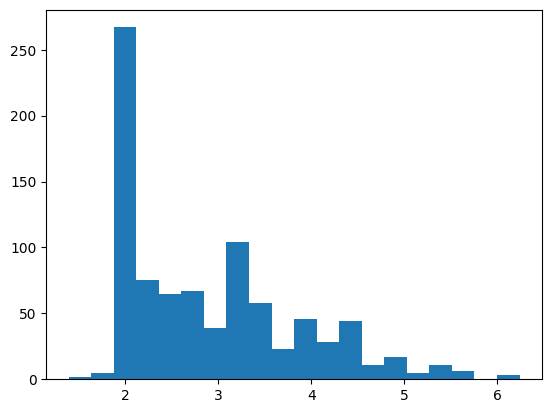

In [47]:
log_fare = np.log(train["Fare"][train["Fare"] > 0])
plt.hist(log_fare, bins = 20)